In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from collections import defaultdict

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("라이브러리 로드 완료")

라이브러리 로드 완료


## 1. Grid Search 결과 로드

In [2]:
# Models 디렉토리 경로
MODELS_DIR = Path('../models')

# Grid search 결과 디렉토리 찾기 (grid_로 시작하는 폴더)
grid_dirs = sorted([d for d in MODELS_DIR.iterdir() if d.is_dir() and d.name.startswith('grid_')])

print(f"총 {len(grid_dirs)}개의 grid search 결과 발견")
print(f"\n최초 실행: {grid_dirs[0].name if grid_dirs else 'None'}")
print(f"최근 실행: {grid_dirs[-1].name if grid_dirs else 'None'}")

총 40개의 grid search 결과 발견

최초 실행: grid_20251125_135158_001
최근 실행: grid_search


In [3]:
# 모든 grid search 결과 로드
results = []

for grid_dir in grid_dirs:
    config_path = grid_dir / 'vaep_config.json'
    history_path = grid_dir / 'training_history.json'
    
    # config와 history 파일이 모두 있는 경우만 로드
    if config_path.exists() and history_path.exists():
        try:
            with open(config_path, 'r') as f:
                config = json.load(f)
            
            with open(history_path, 'r') as f:
                history = json.load(f)
            
            # 결과 요약 생성
            result = {
                'version': grid_dir.name,
                'learning_rate': config.get('learning_rate', 0.001),
                'batch_size': config.get('batch_size', 2048),
                'hidden_dims': str(config.get('hidden_dims', [])),
                'horizon': config.get('horizon', 5),
                'epochs': config.get('epochs', len(history.get('epoch', []))),
                'scheduler': config.get('scheduler', 'none'),
                'best_epoch': history.get('best_epoch', len(history.get('epoch', []))),
                'best_val_loss': history.get('best_val_loss', min(history.get('val_loss', [float('inf')]))),
                'final_train_loss': history.get('train_loss', [None])[-1],
                'final_val_loss': history.get('val_loss', [None])[-1],
                'min_train_loss': min(history.get('train_loss', [float('inf')])),
                'convergence_speed': None  # 나중에 계산
            }
            
            # 수렴 속도 계산 (validation loss가 0.065 이하로 떨어지는 에폭)
            val_losses = history.get('val_loss', [])
            for i, loss in enumerate(val_losses):
                if loss < 0.065:
                    result['convergence_speed'] = i + 1
                    break
            
            # 전체 history 저장 (나중에 시각화용)
            result['history'] = history
            
            results.append(result)
        except Exception as e:
            print(f"Error loading {grid_dir.name}: {e}")

print(f"\n성공적으로 로드된 결과: {len(results)}개")


성공적으로 로드된 결과: 29개


In [4]:
# DataFrame으로 변환 (history 제외)
df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'history'} for r in results])

print("Grid Search 결과 요약:")
print(f"총 실험 수: {len(df_results)}")
print(f"\n컬럼: {df_results.columns.tolist()}")
print(f"\n기본 통계:")
print(df_results.describe())

Grid Search 결과 요약:
총 실험 수: 29

컬럼: ['version', 'learning_rate', 'batch_size', 'hidden_dims', 'horizon', 'epochs', 'scheduler', 'best_epoch', 'best_val_loss', 'final_train_loss', 'final_val_loss', 'min_train_loss', 'convergence_speed']

기본 통계:
       learning_rate  batch_size    horizon     epochs  best_epoch  \
count   2.900000e+01        29.0  29.000000  29.000000   29.000000   
mean    1.000000e-03      2048.0  12.413793  30.172414   30.172414   
std     2.206786e-19         0.0   5.919201   9.772662    9.772662   
min     1.000000e-03      2048.0   5.000000   5.000000    5.000000   
25%     1.000000e-03      2048.0   5.000000  20.000000   20.000000   
50%     1.000000e-03      2048.0  10.000000  35.000000   35.000000   
75%     1.000000e-03      2048.0  20.000000  40.000000   40.000000   
max     1.000000e-03      2048.0  20.000000  40.000000   40.000000   

       best_val_loss  final_train_loss  final_val_loss  min_train_loss  \
count      29.000000         29.000000       29.0000

## 2. 최적 모델 식별

In [5]:
# Best validation loss 기준 Top 10
top_10 = df_results.nsmallest(10, 'best_val_loss')

print("=" * 100)
print("Top 10 Models by Best Validation Loss")
print("=" * 100)
print(top_10[['version', 'learning_rate', 'batch_size', 'hidden_dims', 'horizon', 
              'scheduler', 'best_epoch', 'best_val_loss']].to_string(index=False))

print("\n" + "=" * 100)
print("Best Model Details:")
print("=" * 100)
best_model = df_results.loc[df_results['best_val_loss'].idxmin()]
for key, value in best_model.items():
    if key != 'history':
        print(f"  {key}: {value}")

Top 10 Models by Best Validation Loss
                 version  learning_rate  batch_size hidden_dims  horizon scheduler  best_epoch  best_val_loss
grid_20251125_155556_020          0.001        2048  [256, 128]        5      none          20       0.059304
grid_20251125_155556_019          0.001        2048  [256, 128]        5      none          20       0.059376
grid_20251125_144331_007          0.001        2048   [128, 64]        5      none          40       0.059517
grid_20251125_144331_004          0.001        2048   [128, 64]        5      none          35       0.059539
grid_20251125_144331_008          0.001        2048   [128, 64]        5      none          40       0.059543
grid_20251125_144331_005          0.001        2048   [128, 64]        5      none          35       0.059545
grid_20251125_144331_001          0.001        2048   [128, 64]        5      none          20       0.059751
grid_20251125_144331_002          0.001        2048   [128, 64]        5      none

## 3. 하이퍼파라미터별 성능 분석

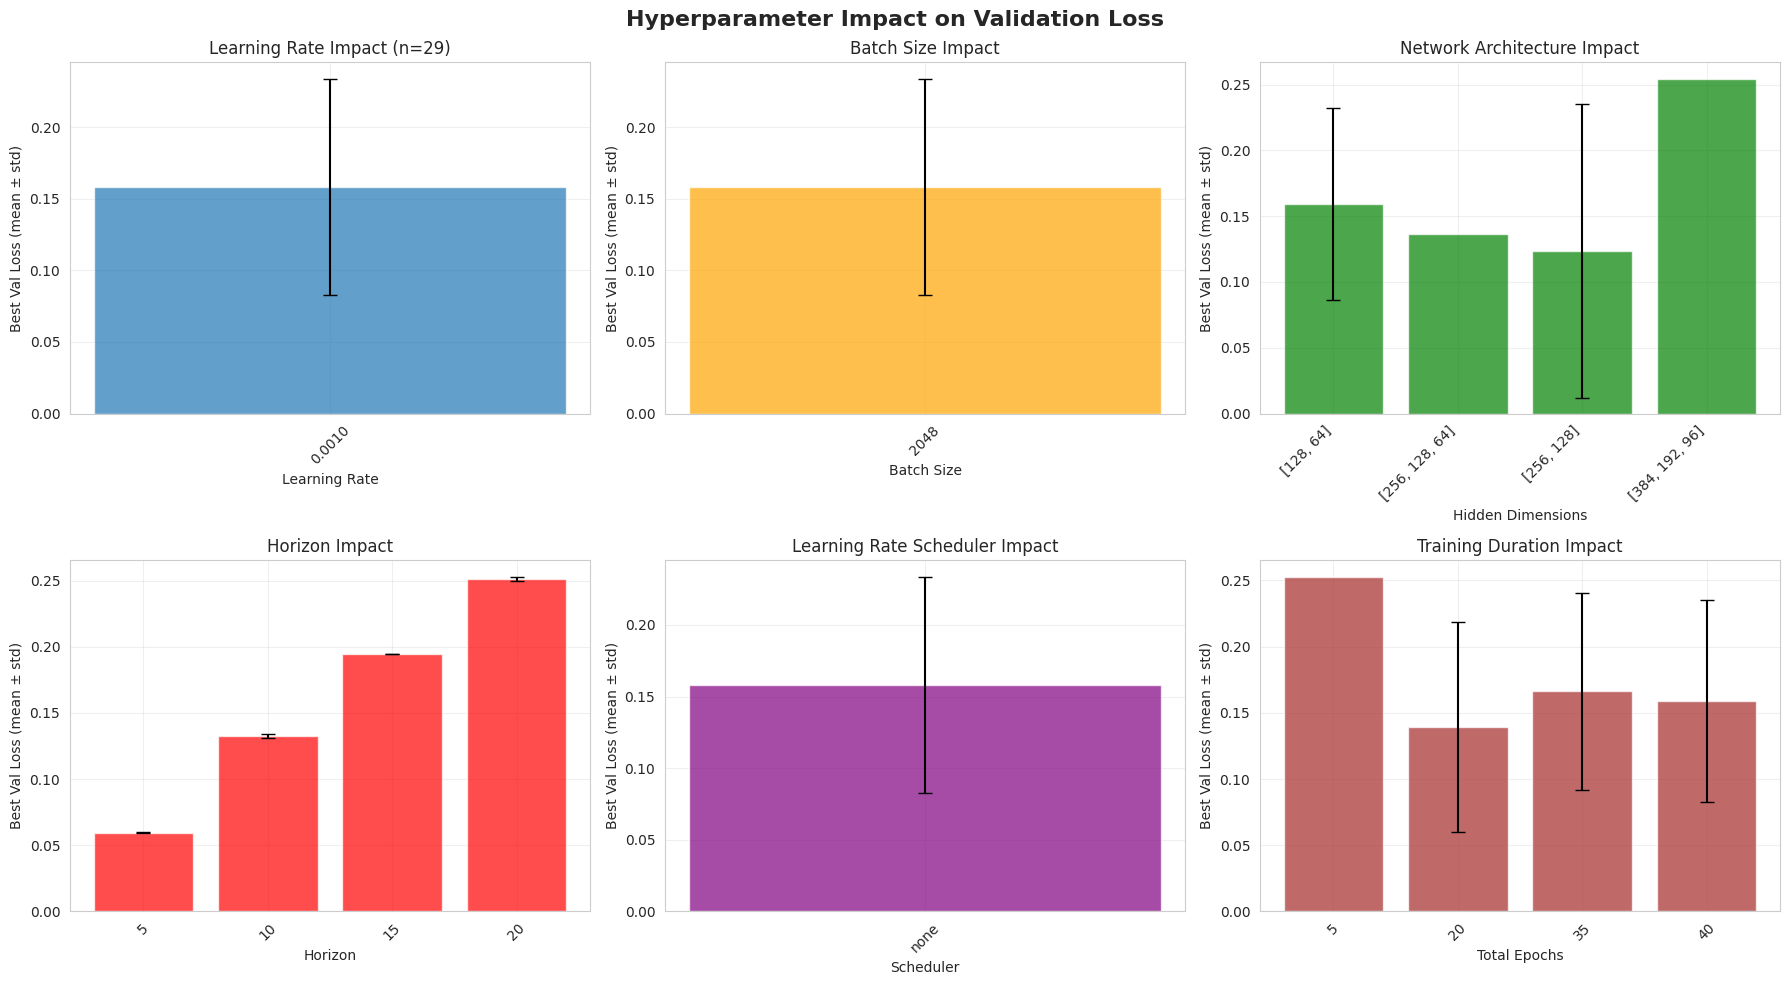

In [6]:
# Learning Rate 영향
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Hyperparameter Impact on Validation Loss', fontsize=16, fontweight='bold')

# 1. Learning Rate
lr_stats = df_results.groupby('learning_rate')['best_val_loss'].agg(['mean', 'std', 'min', 'count'])
axes[0, 0].bar(range(len(lr_stats)), lr_stats['mean'], yerr=lr_stats['std'], capsize=5, alpha=0.7)
axes[0, 0].set_xticks(range(len(lr_stats)))
axes[0, 0].set_xticklabels([f"{lr:.4f}" for lr in lr_stats.index], rotation=45)
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('Best Val Loss (mean ± std)')
axes[0, 0].set_title(f'Learning Rate Impact (n={len(df_results)})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Batch Size
bs_stats = df_results.groupby('batch_size')['best_val_loss'].agg(['mean', 'std', 'min', 'count'])
axes[0, 1].bar(range(len(bs_stats)), bs_stats['mean'], yerr=bs_stats['std'], capsize=5, alpha=0.7, color='orange')
axes[0, 1].set_xticks(range(len(bs_stats)))
axes[0, 1].set_xticklabels(bs_stats.index, rotation=45)
axes[0, 1].set_xlabel('Batch Size')
axes[0, 1].set_ylabel('Best Val Loss (mean ± std)')
axes[0, 1].set_title(f'Batch Size Impact')
axes[0, 1].grid(True, alpha=0.3)

# 3. Hidden Dims
hd_stats = df_results.groupby('hidden_dims')['best_val_loss'].agg(['mean', 'std', 'min', 'count'])
axes[0, 2].bar(range(len(hd_stats)), hd_stats['mean'], yerr=hd_stats['std'], capsize=5, alpha=0.7, color='green')
axes[0, 2].set_xticks(range(len(hd_stats)))
axes[0, 2].set_xticklabels(hd_stats.index, rotation=45, ha='right')
axes[0, 2].set_xlabel('Hidden Dimensions')
axes[0, 2].set_ylabel('Best Val Loss (mean ± std)')
axes[0, 2].set_title(f'Network Architecture Impact')
axes[0, 2].grid(True, alpha=0.3)

# 4. Horizon
h_stats = df_results.groupby('horizon')['best_val_loss'].agg(['mean', 'std', 'min', 'count'])
axes[1, 0].bar(range(len(h_stats)), h_stats['mean'], yerr=h_stats['std'], capsize=5, alpha=0.7, color='red')
axes[1, 0].set_xticks(range(len(h_stats)))
axes[1, 0].set_xticklabels(h_stats.index, rotation=45)
axes[1, 0].set_xlabel('Horizon')
axes[1, 0].set_ylabel('Best Val Loss (mean ± std)')
axes[1, 0].set_title(f'Horizon Impact')
axes[1, 0].grid(True, alpha=0.3)

# 5. Scheduler
s_stats = df_results.groupby('scheduler')['best_val_loss'].agg(['mean', 'std', 'min', 'count'])
axes[1, 1].bar(range(len(s_stats)), s_stats['mean'], yerr=s_stats['std'], capsize=5, alpha=0.7, color='purple')
axes[1, 1].set_xticks(range(len(s_stats)))
axes[1, 1].set_xticklabels(s_stats.index, rotation=45)
axes[1, 1].set_xlabel('Scheduler')
axes[1, 1].set_ylabel('Best Val Loss (mean ± std)')
axes[1, 1].set_title(f'Learning Rate Scheduler Impact')
axes[1, 1].grid(True, alpha=0.3)

# 6. Epochs
e_stats = df_results.groupby('epochs')['best_val_loss'].agg(['mean', 'std', 'min', 'count'])
axes[1, 2].bar(range(len(e_stats)), e_stats['mean'], yerr=e_stats['std'], capsize=5, alpha=0.7, color='brown')
axes[1, 2].set_xticks(range(len(e_stats)))
axes[1, 2].set_xticklabels(e_stats.index, rotation=45)
axes[1, 2].set_xlabel('Total Epochs')
axes[1, 2].set_ylabel('Best Val Loss (mean ± std)')
axes[1, 2].set_title(f'Training Duration Impact')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 학습 곡선 비교

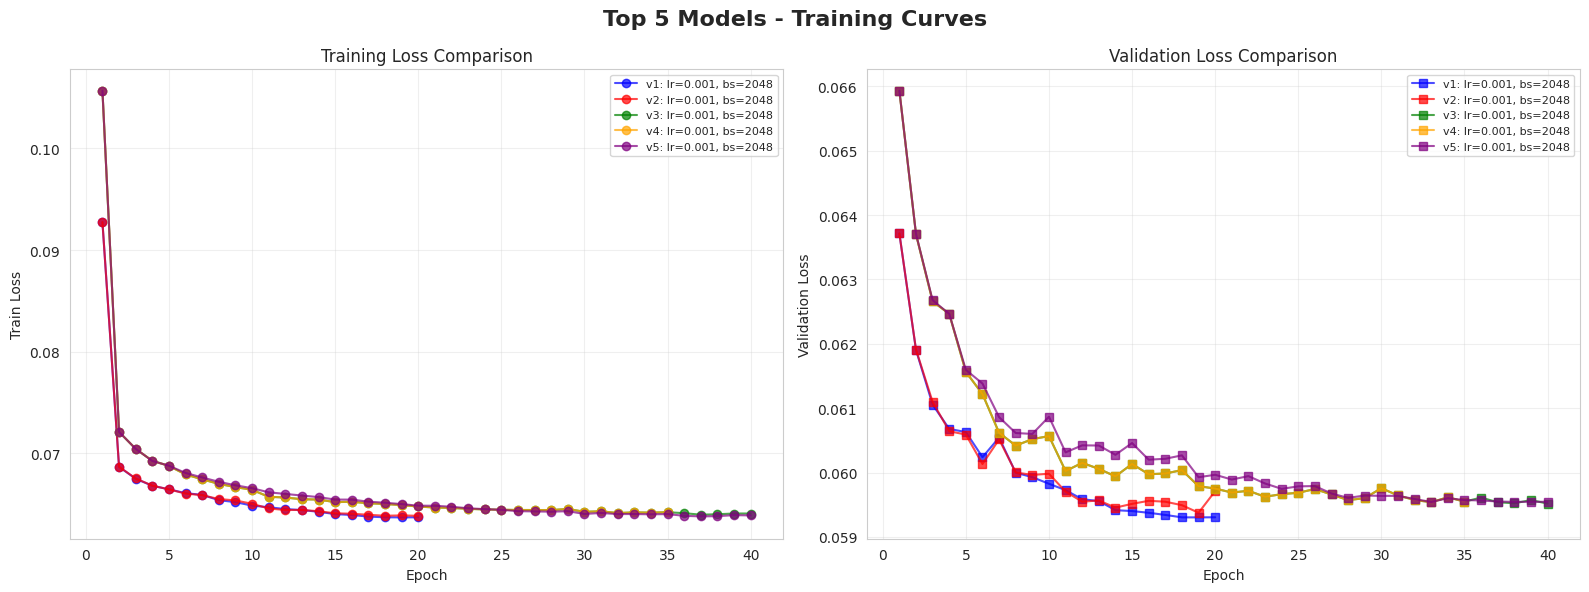


Top 5 Models Summary:
                 version  learning_rate  batch_size hidden_dims scheduler  best_val_loss
grid_20251125_155556_020          0.001        2048  [256, 128]      none       0.059304
grid_20251125_155556_019          0.001        2048  [256, 128]      none       0.059376
grid_20251125_144331_007          0.001        2048   [128, 64]      none       0.059517
grid_20251125_144331_004          0.001        2048   [128, 64]      none       0.059539
grid_20251125_144331_008          0.001        2048   [128, 64]      none       0.059543


In [7]:
# Top 5 모델의 학습 곡선 비교
top_5_indices = df_results.nsmallest(5, 'best_val_loss').index
top_5_results = [results[i] for i in top_5_indices]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Top 5 Models - Training Curves', fontsize=16, fontweight='bold')

colors = ['blue', 'red', 'green', 'orange', 'purple']

for idx, result in enumerate(top_5_results):
    history = result['history']
    epochs = history['epoch']
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    
    label = f"v{idx+1}: lr={result['learning_rate']}, bs={result['batch_size']}"
    
    # Training Loss
    axes[0].plot(epochs, train_loss, marker='o', linestyle='-', label=label, color=colors[idx], alpha=0.7)
    
    # Validation Loss
    axes[1].plot(epochs, val_loss, marker='s', linestyle='-', label=label, color=colors[idx], alpha=0.7)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 5 Models Summary:")
print(df_results.loc[top_5_indices, ['version', 'learning_rate', 'batch_size', 'hidden_dims', 
                                      'scheduler', 'best_val_loss']].to_string(index=False))

## 5. 수렴 속도 분석

목표 성능(0.065) 달성 모델: 8/29 (27.6%)

Top 10 Fastest Converging Models
                 version  learning_rate  batch_size scheduler  convergence_speed  best_val_loss
grid_20251125_155556_019          0.001        2048      none                1.0       0.059376
grid_20251125_155556_020          0.001        2048      none                1.0       0.059304
grid_20251125_144331_001          0.001        2048      none                2.0       0.059751
grid_20251125_144331_002          0.001        2048      none                2.0       0.059885
grid_20251125_144331_005          0.001        2048      none                2.0       0.059545
grid_20251125_144331_004          0.001        2048      none                2.0       0.059539
grid_20251125_144331_008          0.001        2048      none                2.0       0.059543
grid_20251125_144331_007          0.001        2048      none                2.0       0.059517


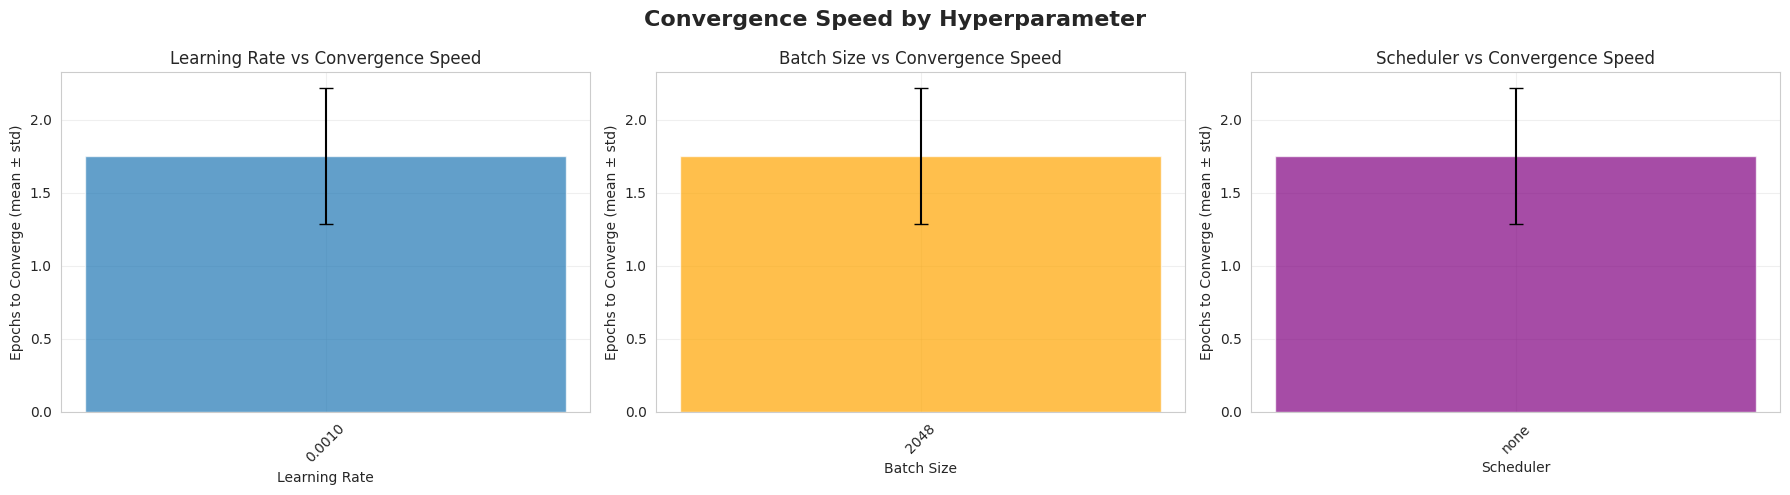

In [8]:
# 수렴 속도 분석 (0.065 이하 도달 시간)
df_converged = df_results[df_results['convergence_speed'].notna()].copy()

print(f"목표 성능(0.065) 달성 모델: {len(df_converged)}/{len(df_results)} ({len(df_converged)/len(df_results)*100:.1f}%)")

if len(df_converged) > 0:
    # 가장 빠르게 수렴한 모델들
    fastest_10 = df_converged.nsmallest(10, 'convergence_speed')
    
    print("\n" + "=" * 100)
    print("Top 10 Fastest Converging Models")
    print("=" * 100)
    print(fastest_10[['version', 'learning_rate', 'batch_size', 'scheduler', 
                      'convergence_speed', 'best_val_loss']].to_string(index=False))
    
    # 하이퍼파라미터별 수렴 속도
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Convergence Speed by Hyperparameter', fontsize=16, fontweight='bold')
    
    # Learning Rate
    lr_conv = df_converged.groupby('learning_rate')['convergence_speed'].agg(['mean', 'std', 'min', 'count'])
    axes[0].bar(range(len(lr_conv)), lr_conv['mean'], yerr=lr_conv['std'], capsize=5, alpha=0.7)
    axes[0].set_xticks(range(len(lr_conv)))
    axes[0].set_xticklabels([f"{lr:.4f}" for lr in lr_conv.index], rotation=45)
    axes[0].set_xlabel('Learning Rate')
    axes[0].set_ylabel('Epochs to Converge (mean ± std)')
    axes[0].set_title('Learning Rate vs Convergence Speed')
    axes[0].grid(True, alpha=0.3)
    
    # Batch Size
    bs_conv = df_converged.groupby('batch_size')['convergence_speed'].agg(['mean', 'std', 'min', 'count'])
    axes[1].bar(range(len(bs_conv)), bs_conv['mean'], yerr=bs_conv['std'], capsize=5, alpha=0.7, color='orange')
    axes[1].set_xticks(range(len(bs_conv)))
    axes[1].set_xticklabels(bs_conv.index, rotation=45)
    axes[1].set_xlabel('Batch Size')
    axes[1].set_ylabel('Epochs to Converge (mean ± std)')
    axes[1].set_title('Batch Size vs Convergence Speed')
    axes[1].grid(True, alpha=0.3)
    
    # Scheduler
    s_conv = df_converged.groupby('scheduler')['convergence_speed'].agg(['mean', 'std', 'min', 'count'])
    axes[2].bar(range(len(s_conv)), s_conv['mean'], yerr=s_conv['std'], capsize=5, alpha=0.7, color='purple')
    axes[2].set_xticks(range(len(s_conv)))
    axes[2].set_xticklabels(s_conv.index, rotation=45)
    axes[2].set_xlabel('Scheduler')
    axes[2].set_ylabel('Epochs to Converge (mean ± std)')
    axes[2].set_title('Scheduler vs Convergence Speed')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ 목표 성능(0.065)에 도달한 모델이 없습니다.")

## 6. 과적합(Overfitting) 분석

Overfitting Analysis

Train-Val Gap Statistics:
  Mean gap: -0.010104
  Median gap: -0.011499
  Min gap: -0.017316
  Max gap: -0.004159

Top 10 Models with Best Generalization (smallest train-val gap)
                 version  learning_rate  batch_size scheduler  final_train_loss  final_val_loss  train_val_gap
grid_20251125_161859_001          0.001        2048      none          0.269991        0.252674      -0.017316
grid_20251125_161645_002          0.001        2048      none          0.271097        0.254218      -0.016879
grid_20251125_155556_014          0.001        2048      none          0.266241        0.250965      -0.015276
grid_20251125_155556_013          0.001        2048      none          0.265676        0.251105      -0.014571
grid_20251125_155556_017          0.001        2048      none          0.264790        0.250533      -0.014257
grid_20251125_155556_015          0.001        2048      none          0.264870        0.250639      -0.014231
grid_20251125_155556_0

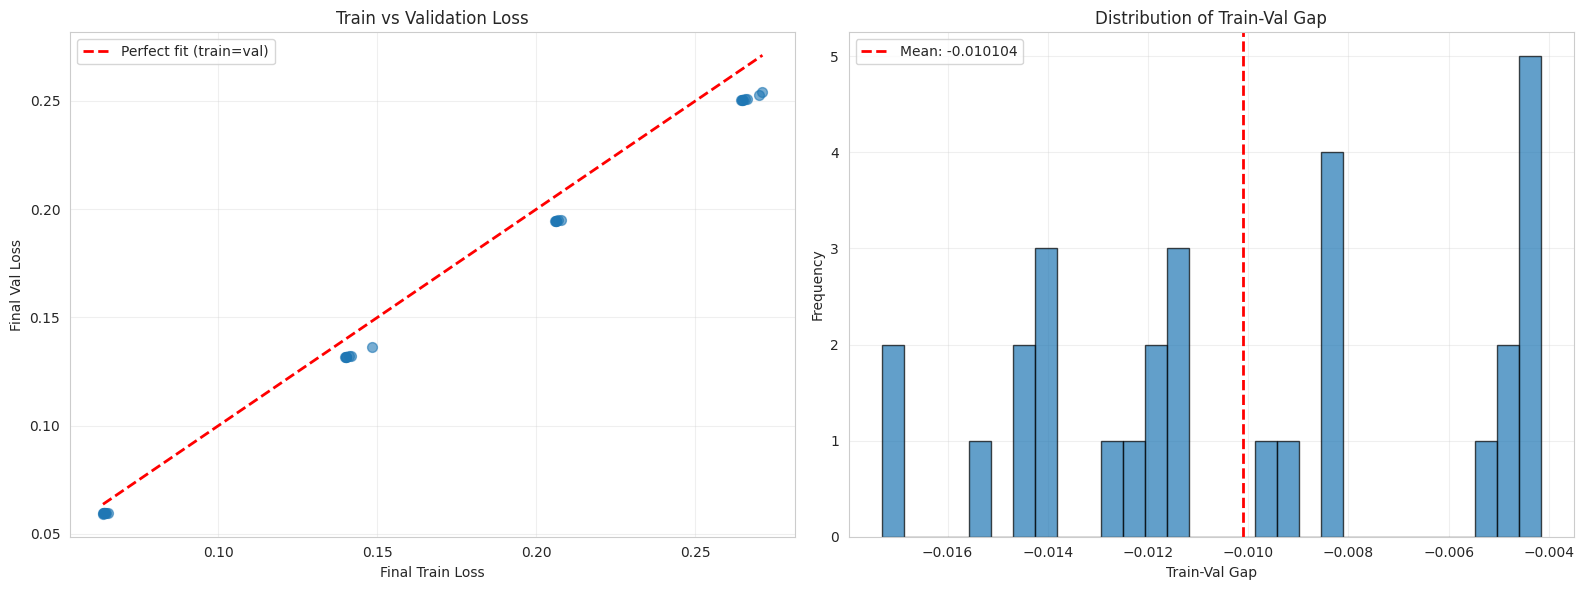

In [9]:
# Train-Val Loss Gap 계산
df_results['train_val_gap'] = df_results['final_val_loss'] - df_results['final_train_loss']
df_results['overfit_score'] = df_results['train_val_gap'] / df_results['final_train_loss']

# 과적합 정도별 분류
print("=" * 100)
print("Overfitting Analysis")
print("=" * 100)
print(f"\nTrain-Val Gap Statistics:")
print(f"  Mean gap: {df_results['train_val_gap'].mean():.6f}")
print(f"  Median gap: {df_results['train_val_gap'].median():.6f}")
print(f"  Min gap: {df_results['train_val_gap'].min():.6f}")
print(f"  Max gap: {df_results['train_val_gap'].max():.6f}")

# Gap이 작은 모델 (잘 일반화되는 모델)
best_generalization = df_results.nsmallest(10, 'train_val_gap')
print("\n" + "=" * 100)
print("Top 10 Models with Best Generalization (smallest train-val gap)")
print("=" * 100)
print(best_generalization[['version', 'learning_rate', 'batch_size', 'scheduler', 
                           'final_train_loss', 'final_val_loss', 'train_val_gap']].to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Train vs Val Loss
axes[0].scatter(df_results['final_train_loss'], df_results['final_val_loss'], alpha=0.6, s=50)
axes[0].plot([df_results['final_train_loss'].min(), df_results['final_train_loss'].max()],
             [df_results['final_train_loss'].min(), df_results['final_train_loss'].max()],
             'r--', label='Perfect fit (train=val)', linewidth=2)
axes[0].set_xlabel('Final Train Loss')
axes[0].set_ylabel('Final Val Loss')
axes[0].set_title('Train vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram: Train-Val Gap Distribution
axes[1].hist(df_results['train_val_gap'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(df_results['train_val_gap'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_results["train_val_gap"].mean():.6f}', linewidth=2)
axes[1].set_xlabel('Train-Val Gap')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Train-Val Gap')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 최종 권장사항

In [10]:
print("=" * 100)
print("GRID SEARCH FINAL RECOMMENDATIONS")
print("=" * 100)

# 1. 최고 성능 모델
best_val = df_results.loc[df_results['best_val_loss'].idxmin()]
print("\n1️⃣  BEST VALIDATION LOSS MODEL:")
print(f"   Version: {best_val['version']}")
print(f"   Learning Rate: {best_val['learning_rate']}")
print(f"   Batch Size: {best_val['batch_size']}")
print(f"   Hidden Dims: {best_val['hidden_dims']}")
print(f"   Horizon: {best_val['horizon']}")
print(f"   Scheduler: {best_val['scheduler']}")
print(f"   Best Val Loss: {best_val['best_val_loss']:.6f} (epoch {best_val['best_epoch']})")

# 2. 최고 일반화 모델
best_gen = df_results.loc[df_results['train_val_gap'].idxmin()]
print("\n2️⃣  BEST GENERALIZATION MODEL:")
print(f"   Version: {best_gen['version']}")
print(f"   Learning Rate: {best_gen['learning_rate']}")
print(f"   Batch Size: {best_gen['batch_size']}")
print(f"   Hidden Dims: {best_gen['hidden_dims']}")
print(f"   Train-Val Gap: {best_gen['train_val_gap']:.6f}")
print(f"   Best Val Loss: {best_gen['best_val_loss']:.6f}")

# 3. 가장 빠른 수렴
if len(df_converged) > 0:
    fastest = df_converged.loc[df_converged['convergence_speed'].idxmin()]
    print("\n3️⃣  FASTEST CONVERGENCE MODEL:")
    print(f"   Version: {fastest['version']}")
    print(f"   Learning Rate: {fastest['learning_rate']}")
    print(f"   Batch Size: {fastest['batch_size']}")
    print(f"   Scheduler: {fastest['scheduler']}")
    print(f"   Convergence Speed: {fastest['convergence_speed']} epochs")
    print(f"   Best Val Loss: {fastest['best_val_loss']:.6f}")

# 4. 하이퍼파라미터 권장값
print("\n4️⃣  RECOMMENDED HYPERPARAMETERS (based on top 10% models):")
top_10_pct = df_results.nsmallest(max(1, len(df_results) // 10), 'best_val_loss')
print(f"   Learning Rate: {top_10_pct['learning_rate'].mode().values[0] if len(top_10_pct) > 0 else 'N/A'} (most common)")
print(f"   Batch Size: {top_10_pct['batch_size'].mode().values[0] if len(top_10_pct) > 0 else 'N/A'} (most common)")
print(f"   Scheduler: {top_10_pct['scheduler'].mode().values[0] if len(top_10_pct) > 0 else 'N/A'} (most common)")
print(f"   Avg Best Val Loss: {top_10_pct['best_val_loss'].mean():.6f}")

print("\n" + "=" * 100)
print("분석 완료! 위 결과를 바탕으로 최적 모델을 선택하세요.")
print("=" * 100)

GRID SEARCH FINAL RECOMMENDATIONS

1️⃣  BEST VALIDATION LOSS MODEL:
   Version: grid_20251125_155556_020
   Learning Rate: 0.001
   Batch Size: 2048
   Hidden Dims: [256, 128]
   Horizon: 5
   Scheduler: none
   Best Val Loss: 0.059304 (epoch 20)

2️⃣  BEST GENERALIZATION MODEL:
   Version: grid_20251125_161859_001
   Learning Rate: 0.001
   Batch Size: 2048
   Hidden Dims: [256, 128]
   Train-Val Gap: -0.017316
   Best Val Loss: 0.252674

3️⃣  FASTEST CONVERGENCE MODEL:
   Version: grid_20251125_155556_019
   Learning Rate: 0.001
   Batch Size: 2048
   Scheduler: none
   Convergence Speed: 1.0 epochs
   Best Val Loss: 0.059376

4️⃣  RECOMMENDED HYPERPARAMETERS (based on top 10% models):
   Learning Rate: 0.001 (most common)
   Batch Size: 2048 (most common)
   Scheduler: none (most common)
   Avg Best Val Loss: 0.059340

분석 완료! 위 결과를 바탕으로 최적 모델을 선택하세요.


## 8. 결과 저장

In [11]:
# 분석 결과를 CSV로 저장
output_path = MODELS_DIR / 'grid_search' / 'analysis_results.csv'
output_path.parent.mkdir(exist_ok=True)

df_results.drop('history', axis=1, errors='ignore').to_csv(output_path, index=False)
print(f"분석 결과 저장 완료: {output_path}")

# Top 모델 정보 저장
top_models_path = MODELS_DIR / 'grid_search' / 'top_models.txt'
with open(top_models_path, 'w') as f:
    f.write("=" * 100 + "\n")
    f.write("VAEP Grid Search - Top Models Summary\n")
    f.write("=" * 100 + "\n\n")
    
    f.write("Top 10 Models by Validation Loss:\n")
    f.write("-" * 100 + "\n")
    f.write(df_results.nsmallest(10, 'best_val_loss')[['version', 'learning_rate', 'batch_size', 
                                                         'hidden_dims', 'scheduler', 'best_val_loss']].to_string(index=False))
    f.write("\n\n")
    
    f.write("Best Model Details:\n")
    f.write("-" * 100 + "\n")
    best = df_results.loc[df_results['best_val_loss'].idxmin()]
    for key, value in best.items():
        if key != 'history':
            f.write(f"{key}: {value}\n")

print(f"Top 모델 정보 저장 완료: {top_models_path}")

분석 결과 저장 완료: ../models/grid_search/analysis_results.csv
Top 모델 정보 저장 완료: ../models/grid_search/top_models.txt
